I think I have the retrospective sampler working. I think the multivariate normal package in NumPy is better than the one in SciPy. NumPy by default is using SVD for its sampling, but it can be changed to eigendecomposition or to Cholesky. I still do get occassional messages about a covariance being singular, but they aren't fatal errors. 

However, I am seeing that most of the trajectories have some moments of unbounded variance. I'll try to illustrate. 

This first chunk is just all the code that needs to run up until we get the retrospective samples. 

In [4]:
import os
os.getcwd()

'c:\\Users\\brian\\Desktop\\HAYSTAC\\Github\\bk_workspace'

In [5]:
import os
os.chdir("..")
import matplotlib.pyplot as plt
import scipy.linalg
import geopandas as gpd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import numpy as np
import pandas as pd
from datetime import datetime
import time
import math
import matplotlib.pyplot as plt
import matplotlib.dates
import matplotlib.colors as mcolors
from sklearn.preprocessing import normalize

import random
os.chdir("bk_workspace/Utilities")
from Poisson import FF_Poisson, RA_Poisson
from Bernoulli import FF_Bernoulli, RA_Bernoulli
from Recouple_DGM2 import Recouple_DGM2
from BK_functions import RA_Poisson_BK, RA_Bernoulli_BK

#### Load Rio bus data and shapfile 

os.chdir("../../../rio_buses/bus_gps_data")

busData = pd.read_csv('treatedBusDataOnlyRoute.csv')
busData['longitude'] = pd.to_numeric(busData.longitude, errors='coerce')
busData['latitude'] = pd.to_numeric(busData.latitude, errors='coerce')

os.chdir("../../Github")
sf = gpd.read_file("Houjie's Code/Run Rio Data/RioShapeFile/33MUE250GC_SIR.shp")
rio = sf[sf.ID == 1535] # ID of the city of Rio

# Generate spatial grid points
rio_bounds = np.array(rio.bounds).reshape(4,)
cell_size = 0.05 # grid cell size 
lon_coords = np.arange(rio_bounds[0], rio_bounds[2]+cell_size, cell_size) 
lat_coords = np.arange(rio_bounds[1], rio_bounds[3]+cell_size, cell_size)
rio_grid = np.array(np.meshgrid(lon_coords, lat_coords)).\
    reshape(2, len(lon_coords)*len(lat_coords)).T


# Specify a specific bus line within a day
all_bus_line = np.unique(busData.line)
# bus_date = '01-25-2019'; 
# bus_date = ['01-25-2019', '01-26-2019']

bus_subgrid = busData[(-43.3 <= busData.longitude) & (busData.longitude <= -43.2) & \
    (-23 <= busData.latitude) & (busData.latitude <= -22.8)]
busline_subgrid = np.unique(bus_subgrid.line)

bus_date = pd.date_range('02-22-2019', periods=2, freq='24h').strftime('%m-%d-%Y')
sub_bus = busData[np.isin(np.array(busData.line), busline_subgrid[0: 20]) &  \
                  np.isin(busData.date, bus_date) \
                    # & (busData.order == bus_order)
                    ]


bus_time = np.array([np.datetime64(datetime.strptime(t, '%m-%d-%Y%H:%M:%S')) \
                        for t in np.array(sub_bus.date) + np.array(sub_bus.time)])

# Generate time grid points
time_intl = '30min'
time_grid = pd.date_range(bus_date[0], periods=24*1*len(bus_date), freq=time_intl)
# time_grid = time_grid[(np.where(time_grid >= np.min(bus_time))[0][0]-1): len(time_grid)]

bus_id = np.unique(sub_bus.order)
bus_location = (np.zeros((len(bus_id), len(time_grid)-1))-1).astype("int")
for i in range(len(time_grid)-1):
    # i = 0
    print(i)
    t0 = time_grid[i]
    t1 = time_grid[i+1]
    sub_bus_tmp = sub_bus.iloc[(t0 < bus_time) & (bus_time < t1), ]
    for j in range(len(bus_id)):
        print("Running bus", j, "at time ", t0)
        # bus = 'D13022'
        bus = bus_id[j]
        if (sum(sub_bus_tmp.order == bus) != 0):
            sub_bus_tmp_i = sub_bus_tmp.iloc[np.array(sub_bus_tmp.order == bus), :]
            # the point is the largest lat,long point that are smaller than 
            # the bus's latest lat,long point in the current time interval
            lon_point = lon_coords[np.where(lon_coords > sub_bus_tmp_i.longitude.iloc[-1])[0][0]-1]
            lat_point = lat_coords[np.where(lat_coords > sub_bus_tmp_i.latitude.iloc[-1])[0][0]-1]
            
            index = np.where((rio_grid[:,0] == lon_point) & (rio_grid[:,1] == lat_point))[0][0]
            bus_location[j, i] = index
            
        
# After we obtain the bus location at each period, we get the flows
edge_idx = [None] * (bus_location.shape[1]-1)
last_location = bus_location[:, 0]
for i in np.arange(1,bus_location.shape[1]):
    # i = 1
    bus_location_i = np.vstack([last_location, bus_location[:, i]]).T
    # only check buses with observed location in both periods
    edgeIndex_tmp = bus_location_i[np.sum(bus_location_i[:, 0:2] != -1, axis = 1) == 2, ] 
    last_location[bus_location_i[:, 1] != -1] = bus_location_i[bus_location_i[:, 1] != -1, 1]
    edge_idx[i-1] = edgeIndex_tmp[edgeIndex_tmp[:, 0] != edgeIndex_tmp[:, 1], :]
    
    


unique_edges = np.unique(np.vstack([edge_idx[i] for i in range(len(edge_idx))]), axis = 0)
flow_count = np.zeros((unique_edges.shape[0], len(edge_idx)))

unique_nodes = np.unique(unique_edges)
out_flows = np.zeros((len(unique_nodes), len(edge_idx)))
for j in range(len(edge_idx)):
    # edge_i = np.array([981, 1053])
    for k in range(len(unique_nodes)):
        # k = 0
        node = unique_nodes[k]
        out_flows[k, j] = np.sum(edge_idx[j][:, 0] == node)
        
    for i in range(unique_edges.shape[0]):
        edge_i = unique_edges[i, :]
        flow_count[i, j] = \
        np.sum((edge_i[0] == edge_idx[j][:, 0]) & (edge_i[1] == edge_idx[j][:, 1]))
        
out_flows = out_flows.T      

# Now the flow_count, unique_edges, m are the flows for each edge, edge ID, occupancy ratio
TTotal, I = out_flows.shape
T0= 0
TActual = TTotal - T0
m = np.zeros((TActual,I), dtype = 'double')
m[:, (I-1)] = 1
for t in range(TActual):
    for i in range(I):
        if out_flows[t+T0,i] == 0:
            m[t,i] = 0;
        elif out_flows[t+T0, i] <= 10 or out_flows[t+T0-1, i] <= 10:
            m[t, i] = 1
        else:
            m[t, i] = out_flows[t+T0, i]/out_flows[t+T0-1, i]


############################## Fitting DCMM ##################################


eps = 1e-2
flow_count[flow_count == 0] = eps

N = flow_count.shape[0]

# Bernoulli

F_bern = np.array([[1],
                     [0]])
G_bern = np.array([[1, 1], 
                     [0, 1]])
""" F_bern = np.array([[1],
                    [0],
                    [1],
                    [0]])

period = 12
G_bern = scipy.linalg.block_diag([[1, 1], 
                                [0, 1]],
                                [[np.cos(2*np.pi/period), np.sin(2*np.pi/period)],
                                [-np.sin(2*np.pi/period), np.cos(2*np.pi)/period]]) """

delta_bern = 0.95  # Discount factor for evolution variance
sampleSize_bern = 1000 # Sample size of posterior and predictions

# Poisson
F_pois = np.array([[1],
                     [0]])
G_pois = np.array([[1, 1], 
                    [0, 1]])
#F_pois = np.array([[1],
#                    [0],
#                    [1],
#                    [0]])
#G_pois = scipy.linalg.block_diag([[1, 1], 
#                                [0, 1]],
#                                [[np.cos(2*np.pi/period), np.sin(2*np.pi/period)],
#                                [-np.sin(2*np.pi/period), np.cos(2*np.pi)/period]])

# Augment for Random Effect
F_pois = np.r_[np.array([[1]]), F_pois]
G_pois = scipy.linalg.block_diag(0, G_pois)

delta_pois = 0.99  # Discount factor for evolution variance
RE_rho_pois = .999 # Discount factor for random effect. When = 1, no RE
conditional_shift_pois = 1 # Shift of conditional Poisson
sampleSize_pois = 1000 # Sample size of posterior and predictions

sampleSize_dgm = 500
# Fit all individual dynamic models
phi_samp = np.zeros((N, TActual, sampleSize_dgm))

# Get learned parameters
rt_bern_all = np.zeros((TActual, N))
st_bern_all = np.zeros((TActual, N))
rt_pois_all = np.zeros((TActual, N))
st_pois_all = np.zeros((TActual, N))

ssrt_bern_all = np.zeros((TActual, N))
ssst_bern_all = np.zeros((TActual, N))
ssrt_pois_all = np.zeros((TActual, N))
ssst_pois_all = np.zeros((TActual, N))

nSample = 1000
pois_sample = np.zeros((nSample, TActual, N))
bern_sample = np.zeros((nSample, TActual, N))
st = time.time()
for n in range(N):
    # n = 0
    print(n)
    # Bern: Forward Filtering
    mN = m[:,np.where(unique_nodes == unique_edges[n,0])[0]]
    
    st = time.time()
    mt_bern, Ct_bern, at_bern, Rt_bern, rt_bern, st_bern, skipped_bern = \
    FF_Bernoulli(F_bern, G_bern, delta_bern, flow_count, n, T0, TActual, eps)
    ed = time.time()
    # ed - st

    # Bern: Retrospective Analysis
    st = time.time()
    [sat_bern, sRt_bern, ssrt_bern, ssst_bern, RA_prob] = \
        RA_Bernoulli(TActual, F_bern, G_bern, mt_bern, \
                     Ct_bern, at_bern, Rt_bern, skipped_bern,\
                     nSample = nSample)
    ed = time.time()
    # ed - st
    
    # Forward Filtering
    st = time.time()
    [mt_pois, Ct_pois, at_pois, Rt_pois, rt_pois, ct_pois, skipped_pois] = \
        FF_Poisson(F_pois, G_pois, delta_pois, flow_count, n, mN, T0, TActual, \
                   eps, RE_rho_pois, conditional_shift_pois)
    ed = time.time()
    # ed - st
    
    # Retrospective Analysis
    [sat_pois, sRt_pois, ssrt_pois, ssct_pois, RA_rate] = \
        RA_Poisson(TActual, F_pois, G_pois, mt_pois, \
                   Ct_pois, at_pois, Rt_pois, skipped_pois,
                   nSample = nSample)
    
    # BK Retrospective
    prob_samps = RA_Bernoulli_BK(TActual, F_bern, G_bern, mt_bern, \
                   Ct_bern, at_bern, Rt_bern, skipped_bern,
                   nSample = nSample)
    rate_samps = RA_Poisson_BK(TActual, F_pois, G_pois, mt_pois, \
                   Ct_pois, at_pois, Rt_pois, skipped_pois,
                   nSample = nSample)
    
    # Troubleshooting
    #[F, G, mt, Ct, at, Rt] = [F_pois, G_pois, mt_pois, Ct_pois, at_pois, Rt_pois]
    #[F, G, mt, Ct, at, Rt] = [F_bern, G_bern, mt_bern, Ct_bern, at_bern, Rt_bern]
    # Store them
    rt_bern_all[:, n] = rt_bern
    st_bern_all[:, n] = st_bern
    rt_pois_all[:, n] = rt_pois
    st_pois_all[:, n] = ct_pois

    ssrt_bern_all[:, n] = ssrt_bern
    ssst_bern_all[:, n] = ssst_bern
    ssrt_pois_all[:, n] = ssrt_pois
    ssst_pois_all[:, n] = ssct_pois
    bern_sample[:, :, n] = prob_samps
    pois_sample[:, :,  n] = rate_samps

0
Running bus 0 at time  2019-02-22 00:00:00
Running bus 1 at time  2019-02-22 00:00:00
Running bus 2 at time  2019-02-22 00:00:00
Running bus 3 at time  2019-02-22 00:00:00
Running bus 4 at time  2019-02-22 00:00:00
Running bus 5 at time  2019-02-22 00:00:00
Running bus 6 at time  2019-02-22 00:00:00
Running bus 7 at time  2019-02-22 00:00:00
Running bus 8 at time  2019-02-22 00:00:00
Running bus 9 at time  2019-02-22 00:00:00
Running bus 10 at time  2019-02-22 00:00:00
Running bus 11 at time  2019-02-22 00:00:00
Running bus 12 at time  2019-02-22 00:00:00
Running bus 13 at time  2019-02-22 00:00:00
Running bus 14 at time  2019-02-22 00:00:00
Running bus 15 at time  2019-02-22 00:00:00
Running bus 16 at time  2019-02-22 00:00:00
Running bus 17 at time  2019-02-22 00:00:00
Running bus 18 at time  2019-02-22 00:00:00
Running bus 19 at time  2019-02-22 00:00:00
Running bus 20 at time  2019-02-22 00:00:00
Running bus 21 at time  2019-02-22 00:00:00
Running bus 22 at time  2019-02-22 00:00

Now, I compare the mean implied by the parameters of the forward filtering, with the mean of the of the retrospective samples. First, the FF. 

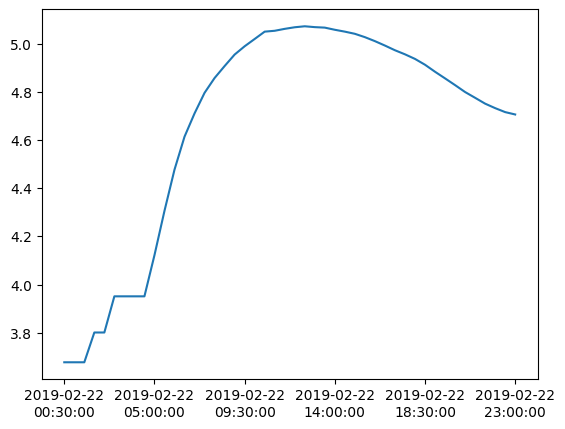

In [6]:
ff_pois_mean= ssrt_pois_all / ssst_pois_all

plot_time = np.array([x.date().isoformat() + "\n" + x.time().isoformat() \
                      for x in time_grid[np.arange(1, TActual+1)]])
plt.plot(plot_time, (ff_pois_mean[:, 10]))
plt.xticks(plot_time[np.linspace(0, len(plot_time)-1, 6, dtype=int)])
plt.show()

For the RA, I am averaging over the 0th axis of the array, which are the samples. We see extremely large spikes in the RA. Note the graphic is on the scale of 10^8.

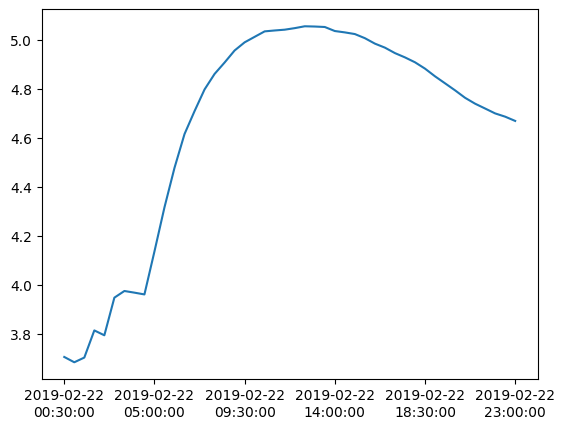

In [7]:
ra_pois_mean = np.mean(pois_sample, 0)
plot_time = np.array([x.date().isoformat() + "\n" + x.time().isoformat() \
                      for x in time_grid[np.arange(1, TActual+1)]])
plt.plot(plot_time, (ra_pois_mean[:, 10]))
plt.xticks(plot_time[np.linspace(0, len(plot_time)-1, 6, dtype=int)])
plt.show()

By looking at the mean values themselves, we can see that most of the time, the two means are very similar. There are just a few moments when the RA is much much larger

In [8]:
print(ff_pois_mean[:, 10])


[3.67742651 3.67742651 3.67742651 3.80111719 3.80111719 3.95131875
 3.95131875 3.95131875 3.95131875 4.12195787 4.30621094 4.47735558
 4.6142854  4.71095228 4.79646904 4.85798876 4.90762947 4.95537668
 4.98983722 5.02011989 5.05064789 5.05425516 5.06222949 5.068858
 5.07293556 5.06938173 5.06734771 5.05843168 5.05066595 5.04166243
 5.02778496 5.01123721 4.99287453 4.97340875 4.95649117 4.93740853
 4.9132066  4.88406063 4.85658193 4.82864716 4.79986261 4.77589935
 4.75157674 4.73300924 4.71647771 4.70662212]


In [9]:
print(ra_pois_mean[:, 10])

[3.70464555 3.6829524  3.70218743 3.81299034 3.7930832  3.9466643
 3.97389621 3.96713292 3.95985678 4.1352639  4.31539014 4.47642917
 4.61432461 4.70783134 4.79647355 4.85975675 4.90633762 4.95549789
 4.98874904 5.01121008 5.03352419 5.03719029 5.04042522 5.04670364
 5.05430366 5.05327141 5.05138279 5.03491614 5.02935779 5.02254453
 5.00574953 4.98348617 4.96711317 4.94484483 4.92733716 4.90738042
 4.88144803 4.85005019 4.82152914 4.79285606 4.76240469 4.73835264
 4.71864213 4.69870946 4.68538734 4.66800431]


It is more clear if we look at the variance of the RA samples.

In [10]:
np.var(pois_sample[:, :, 10], 0)

array([0.43563383, 0.44034772, 0.45375169, 0.51705431, 0.49986474,
       0.56840492, 0.57708214, 0.51255884, 0.54171856, 0.44590322,
       0.37641913, 0.33786366, 0.29236438, 0.27369499, 0.26277927,
       0.24746921, 0.23253276, 0.2135489 , 0.19630238, 0.18318682,
       0.17121633, 0.16339095, 0.15525339, 0.14380051, 0.14382692,
       0.14024313, 0.1368133 , 0.1357117 , 0.13872353, 0.14815215,
       0.1539793 , 0.16662988, 0.17758443, 0.19256225, 0.20959174,
       0.22724076, 0.24539289, 0.27282686, 0.30308202, 0.3363256 ,
       0.36608993, 0.39943198, 0.44144037, 0.4893093 , 0.53264634,
       0.58238261])

This seems to be occuring when flow counts are very low. 

In [11]:
flow_count[10, :]


array([ 0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  2.,  4.,  6.,  9.,
        6., 10.,  7.,  5.,  8.,  7.,  6., 14.,  5.,  6.,  7.,  9.,  6.,
        9.,  6.,  7.,  9.,  9.,  9.,  7.,  5.,  8., 10., 10.,  6.,  7.,
        7.,  3.,  6.,  2.,  4.,  1.,  1.])